In [ ]:
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

import matplotlib.pyplot as plt
import japanize_matplotlib
from PIL import Image
import cv2
%matplotlib inline

In [ ]:
TrainImg_DIR = '../datasets/train_data/'
TestImg_DIR = '../datasets/test_data/'

train_csv = pd.read_csv('../datasets/train.csv')
train_csv = train_csv.sort_values(by=['id'])

sampleSubmit_csv = pd.read_csv('../datasets/sample_submission.csv', header=None)
sampleSubmit_csv.columns = [['id', 'preds']]

x_train = np.array(train_csv['id'])
t_train = np.array(train_csv['target'])
x_test = np.array(sampleSubmit_csv['id']).flatten()

In [ ]:
rng = np.random.RandomState(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
height = 224
width = 224
lr = 1e-5
n_epochs = 500
batch_size = 20
val_ratio = 0.3

In [ ]:
class train_dataset(torch.utils.data.Dataset):
  def __init__(self, x_train, t_train, transform):
    self.x_train = x_train
    self.t_train = t_train.astype("int32")
    self.transform = transform

  def __len__(self):
    return len(self.x_train)

  def __getitem__(self, idx):
    image = Image.open(TrainImg_DIR+self.x_train[idx])
    data = torch.tensor(np.array(image), dtype=torch.float)
    data = torch.transpose(data, 0, 2)
    data = torch.transpose(data, 1, 2)
    label = torch.tensor(self.t_train[idx], dtype=torch.float)
    if self.transform:
      data = self.transform(data)
      return data, label
  
class test_dataset(torch.utils.data.Dataset):
  def __init__(self, x_test, transform):
    self.x_test = x_test
    self.transform = transform
  
  def __len__(self):
    return len(self.x_test)
  
  def __getitem__(self, idx):
    image = Image.open(TestImg_DIR+self.x_test[idx])
    data = torch.tensor(np.array(image), dtype=torch.float)
    data = torch.transpose(data, 0, 2)
    data = torch.transpose(data, 1, 2)
    if self.transform:
      data = self.transform(data)
      return data

In [ ]:
#前処理の定義
transform_train = transforms.Compose([])
transform_test = transforms.Compose([])

transform_train = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=10, expand=True),
        transforms.Resize((height, width)),
        transforms.ToTensor(),
        transforms.Normalize((0.4834, 0.4834, 0.4834),
                             (0.2892, 0.2892, 0.2892)),
    ]
)

transform_test = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((height, width)),
        transforms.ToTensor(),
        transforms.Normalize((0.4834, 0.4834, 0.4834),
                             (0.2892, 0.2892, 0.2892)),
    ]
)

In [ ]:
# データセットインスタンスの作成
trainval_data = train_dataset(x_train, t_train, transform_train)
test_data = test_dataset(x_test, transform_test)

# 学習用データと検証用データを分割
val_size = int(len(trainval_data) * val_ratio)
train_size = len(trainval_data) - val_size
train_data, val_data = torch.utils.data.random_split(
    trainval_data, [train_size, val_size]
)

#dataloaderインスタンス作成
dataloader_train = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    val_data, batch_size=batch_size, shuffle=True
)

dataloader_test = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, shuffle=False
)

In [ ]:
class EarlyStopping:
    """earlystoppingクラス"""

    def __init__(self, patience=5, verbose=False, path='vgg16_flatten_checkpoint_model.pth'):
        """引数：最小値の非更新数カウンタ、表示設定、モデル格納path"""

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.path = path

    def __call__(self, val_loss, model):
        """
        特殊(call)メソッド
        実際に学習ループ内で最小lossを更新したか否かを計算させる部分
        """
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.checkpoint(val_loss, model)
            self.counter = 0

    def checkpoint(self, val_loss, model):
        '''ベストスコア更新時に実行されるチェックポイント関数'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
model_tuned = models.vgg16(pretrained=True)

for param in model_tuned.parameters():
        param.requires_grad = False

in_dim = 25088
out_dim = 1
model_tuned.classifier = nn.Sequential(
    nn.BatchNorm1d(in_dim),
    nn.Linear(in_dim, 4096),
    nn.BatchNorm1d(4096),
    nn.ReLU(True),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(True),
    nn.Dropout(p=0.3),
    nn.Linear(1024, out_dim),
    nn.Sigmoid(),
)
model_tuned.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
from torchsummary import summary
summary(model_tuned, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
optimizer_tuned = optim.AdamW(model_tuned.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer_tuned, T_0=5)
loss_function = nn.BCELoss()
earlystopping = EarlyStopping(patience=10, verbose=True)
losses_train = []
losses_valid = []
accs_train = []
accs_valid = []
for epoch in range(n_epochs):
  
  running_train_losses = []
  running_valid_losses = []

  model_tuned.train()
  n_train = 0
  acc_train = 0
  for x, t in dataloader_train:
    n_train += t.size()[0]

    model_tuned.zero_grad()

    x = x.to(device)
    t = t.to(device)
    
    y = model_tuned.forward(x)
    y = torch.squeeze(y)

    loss = loss_function(y, t)

    loss.backward()

    optimizer_tuned.step()

    pred = (y>=0.5).float()

    acc_train += (pred == t).float().sum().item()
    running_train_losses.append(loss.tolist())

  model_tuned.eval()
  n_val = 0
  acc_val = 0
  for x, t in dataloader_valid:
    n_val += t.size()[0]

    x = x.to(device)
    t = t.to(device)

    y = model_tuned.forward(x)
    y = torch.squeeze(y)

    loss = loss_function(y, t)

    pred = (y>=0.5).float()
    acc_val += (pred == t).float().sum().item()
    running_valid_losses.append(loss.tolist())

  # scheduler.step()
  print(
      "EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]".format(
            epoch,
            np.mean(running_train_losses),
            acc_train / n_train,
            np.mean(running_valid_losses),
            acc_val / n_val,
      )
  )
  accs_train.append(acc_train/n_train)
  accs_valid.append(acc_val/n_val)
  losses_train.append(np.mean(running_train_losses))
  losses_valid.append(np.mean(running_valid_losses))

  earlystopping((np.mean(running_valid_losses)), model_tuned)
  if earlystopping.early_stop:
    print("Early Stopping!")
    break

EPOCH: 0, Train [Loss: 0.749, Accuracy: 0.480], Valid [Loss: 0.677, Accuracy: 0.613]
Validation loss decreased (inf --> 0.676501).  Saving model ...
EPOCH: 1, Train [Loss: 0.668, Accuracy: 0.583], Valid [Loss: 0.627, Accuracy: 0.680]
Validation loss decreased (0.676501 --> 0.626796).  Saving model ...
EPOCH: 2, Train [Loss: 0.615, Accuracy: 0.697], Valid [Loss: 0.586, Accuracy: 0.707]
Validation loss decreased (0.626796 --> 0.586076).  Saving model ...
EPOCH: 3, Train [Loss: 0.551, Accuracy: 0.697], Valid [Loss: 0.526, Accuracy: 0.747]
Validation loss decreased (0.586076 --> 0.525985).  Saving model ...
EPOCH: 4, Train [Loss: 0.535, Accuracy: 0.806], Valid [Loss: 0.477, Accuracy: 0.800]
Validation loss decreased (0.525985 --> 0.477375).  Saving model ...
EPOCH: 5, Train [Loss: 0.482, Accuracy: 0.794], Valid [Loss: 0.431, Accuracy: 0.813]
Validation loss decreased (0.477375 --> 0.431045).  Saving model ...
EPOCH: 6, Train [Loss: 0.440, Accuracy: 0.794], Valid [Loss: 0.423, Accuracy: 0.8

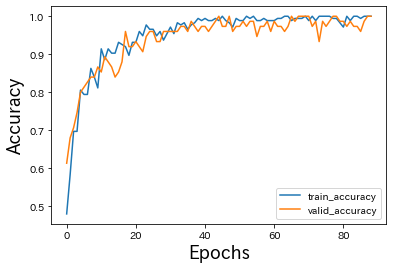

In [ ]:
plt.plot(accs_train, label="train_accuracy")
plt.plot(accs_valid, label="valid_accuracy")
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.legend()
plt.savefig('../outputs/vgg16_flatten/accuracy_curve.png')
plt.show()

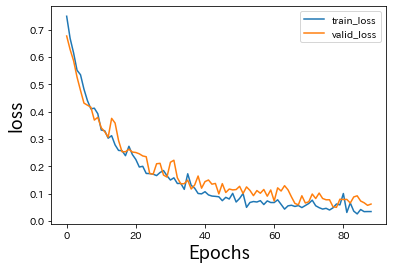

In [ ]:
plt.plot(losses_train, label="train_loss")
plt.plot(losses_valid, label="valid_loss")
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('loss', fontsize=18)
plt.legend()
plt.savefig('../outputs/vgg16_flatten/loss_curve.png')
plt.show()

In [ ]:
model_tuned.load_state_dict(torch.load('./vgg16_flatten_checkpoint_model.pth', map_location=torch.device(device)))
model_tuned.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

In [ ]:
def tentap2list(tentap):
  """
  予測確率と勾配がタプルに格納されているリストから予測確率だけをリストに格納する関数
  """
  probas_list = [tentap[i].item() for i in range(len(tentap))]
  return probas_list

# 検証データに対する予測確率を保存する
target = []
probas = []
for x, t in dataloader_valid:
  x = x.to(device)
  t = t.to(device)
  start.record()
  %time y = model_tuned.forward(x)
  end.record()
  torch.cuda.synchronize()
  elapsed_time = start.elapsed_time(end)
  print(f'GPU times: {elapsed_time / 1000} sec.')
  y = torch.squeeze(y)

  target += t
  probas += y

print(f"probas' length: {len(probas)}\ntarget's length: {len(target)}")

probas_list = tentap2list(probas)
targets_list = tentap2list(target)

targets_arr = np.array(targets_list)
probas_arr = np.array(probas_list)

probas_list = [round(probas_list[i], 4) for i in range(len(probas_list))]

preds = np.where(probas_arr>=0.5, 1.0, 0.0)
print(confusion_matrix(targets_list, preds))

20
CPU times: user 3.69 ms, sys: 140 µs, total: 3.83 ms
Wall time: 3.41 ms
0.15926806640625 ms.
20
CPU times: user 3.67 ms, sys: 0 ns, total: 3.67 ms
Wall time: 3.26 ms
0.11833715057373047 ms.
20
CPU times: user 3.78 ms, sys: 157 µs, total: 3.93 ms
Wall time: 3.52 ms
0.11757977294921874 ms.
15
CPU times: user 2.7 ms, sys: 0 ns, total: 2.7 ms
Wall time: 2.71 ms
0.0676475830078125 ms.
probas' length: 75
target's length: 75
[[45  0]
 [ 0 30]]


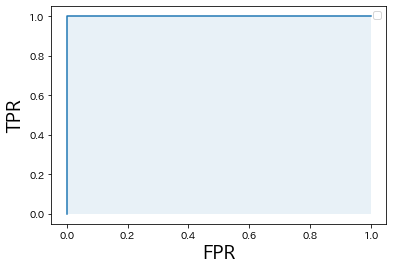

AUC: 1.0000


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
targets_arr = np.array(targets_list)
probas_arr = np.array(probas_list)
fpr, tpr, thresholds = roc_curve(y_true=targets_arr, y_score=probas_arr, pos_label=1)
plt.plot(fpr, tpr)
plt.fill_between(fpr, tpr, 0, alpha=0.1)

plt.xlabel('FPR', fontsize=18)
plt.ylabel('TPR', fontsize=18)
plt.legend()
plt.savefig('/content/drive/MyDrive/university/seminar/castingProducts/outputs/vgg16_flatten/roc_curve.png')
plt.show()
print(f'AUC: {roc_auc_score(targets_list, probas_list):.4f}')